# Project 3: Web APIs & NLP

# Modelling Notebook

In this notebook, we will proceed to use the data gathered in the last notebook in order to model our predictions. We will attempt to utilize multiple modelling techniques and briefly observe how each one performs. Full evaluation of these models will be found in the next notebook, <a href="./Summary.ipynb">here</a>.

For information on how the data was collected, please click <a href="./Data Collection.ipynb">here</a>.

_Note: This notebook takes a long time to run due to the number of simulations (approx. 30 mins), and is only serves as pre-processing for the final 'Summary' notebook. Models are compressed and saved separately in the directory and may be loaded for verification purposes._

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import bz2

#downgrade sklearn to 0.23.2 since the models were originally modelled in that version.
#!pip install scikit-lear --upgrade --user

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

rs = 0 #random state
#import sklearn
#sklearn.__version__

In [2]:
def scorer(model): #plots confusion matrix and get accuracy, precision and recall scores
    # Get predictions
    preds = model.predict(X_test_v)

    plot_confusion_matrix(model, X_test_v, y_test, cmap='GnBu', values_format='d',display_labels={'LifeProTips':1,'YouShouldKnow':0});
    
    print("Training Score:",model.score(X_train_v,y_train))
    print("Testing Score:",model.score(X_test_v,y_test))
    print("\n")
    print(classification_report(y_test, preds))

def save(model, model_name): #save models into a .p file
    sfile = bz2.BZ2File(f'./models/{model_name}.p', 'wb')
    pickle.dump(model, sfile)

In [3]:
df = pd.read_csv('./dataset/data.csv')
df.head()

,subreddit,id,title,selftext,created_utc,text
0,LifeProTips,p8ikjn,LPT: Before a predictable natural disaster (li...,.,1629510198,Before a predictable natural disaster (like a ...
1,LifeProTips,p8dc4d,LPT: Many companies that put strong emphasis o...,[removed],1629491499,Many companies that put strong emphasis on bei...
2,LifeProTips,p88dnk,LPT: Scholastic Book Fair idea: Slide the teac...,[removed],1629475987,Scholastic Book Fair idea: Slide the teacher $...
3,LifeProTips,p84c18,LPT: Deliberately follow people who have oppos...,[removed],1629463005,Deliberately follow people who have opposite b...
4,LifeProTips,o2n2ys,"LPT: When you are giving a presentation, alway...",.,1624016255,"When you are giving a presentation, always inc..."


### Train Test Split

Here we set the X and y prior to splitting and modelling. X is made up of the concatenated text between `title` and `selftext` that has been cleaned in the prior notebook.

In [4]:
X = df['text']
y = df['subreddit'].map({'LifeProTips':1,'YouShouldKnow':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=rs)

### Count Vectorizer

For our baseline model, we will be using the random forest model. However, before we can fit it, we need to further sort our X into a bag of words.

In [5]:
stopwords=[]
for i in CountVectorizer(stop_words = 'english').get_stop_words():
    stopwords.append(i)
    
#add additional stop words based on previous cycles of this process below
extrawords = ['https','com','www','don', 'org','http','ll','gt','ve','edit','really'] 
for i in extrawords:
    stopwords.append(i)

In [6]:
cvec=  CountVectorizer(stop_words=stopwords, max_df=0.7, ngram_range=(1,4), min_df=2, max_features=len(X_train))

X_train_v = cvec.fit_transform(X_train)
X_train_v

<2183x2183 sparse matrix of type '<class 'numpy.int64'>'
	with 48178 stored elements in Compressed Sparse Row format>

In [7]:
feature_names = cvec.get_feature_names()
# save list of feature names
fname= feature_names
save(feature_names,"fname")

In [8]:
X_test_v = cvec.transform(X_test) # transform test set
X_test_v

<728x2183 sparse matrix of type '<class 'numpy.int64'>'
	with 13924 stored elements in Compressed Sparse Row format>

### Baseline Model: Random Forest

We instantiate a vanilla `RandomForestClassifier` with a fixed `random_state` and observe the scores.

In [9]:
baseline = RandomForestClassifier(random_state=rs)
baseline.fit(X_train_v,y_train)

RandomForestClassifier(random_state=0)

Training Score: 0.9990838295923041
Testing Score: 0.7568681318681318


              precision    recall  f1-score   support

           0       0.71      0.86      0.78       360
           1       0.83      0.66      0.73       368

    accuracy                           0.76       728
   macro avg       0.77      0.76      0.75       728
weighted avg       0.77      0.76      0.75       728



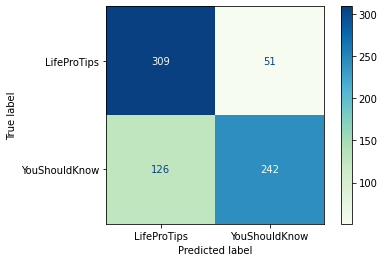

In [10]:
scorer(baseline)

In [11]:
baseline_importance = zip(fname, baseline.feature_importances_)
baseline_df = pd.DataFrame(baseline_importance,columns=['feature','feature_importance'])
baseline_df.sort_values("feature_importance",ascending=False).head(10)

,feature,feature_importance
770,free,0.014638
2121,website,0.012408
277,called,0.009725
1084,link,0.009096
103,amazon,0.008427
819,google,0.007135
1820,states,0.005732
1740,site,0.005256
965,information,0.005038
150,article,0.004732


In [12]:
# Save Model
save(baseline,"baseline")

### Gridsearch on Random Forest

Next we will try and tune the hyperparameters on our random forest model with some gridsearch cross validation to observe if we can get better results.

In [80]:
rf_params = {
    'n_estimators':[5,10,15],
    'max_depth':[5,10,15],
    'criterion':['gini','entropy'],
    'max_leaf_nodes':[5,10,15]
}

In [87]:
rf = GridSearchCV(baseline,
                  param_grid=rf_params,
                  verbose = 1,
                  n_jobs = -1,
                  return_train_score=True,
                  scoring="accuracy",
                  cv=5) # 5-fold cross-validation.

In [88]:
rf.fit(X_train_v,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    5.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'max_leaf_nodes': [5, 10, 15],
                         'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='accuracy', verbose=1)

CV Score:  0.6891405309032713
Training Score: 0.7343105817682088
Testing Score: 0.6991758241758241


              precision    recall  f1-score   support

           0       0.79      0.53      0.63       360
           1       0.65      0.87      0.74       368

    accuracy                           0.70       728
   macro avg       0.72      0.70      0.69       728
weighted avg       0.72      0.70      0.69       728



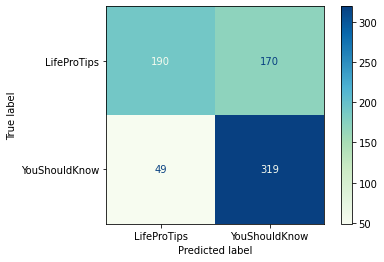

In [89]:
print("CV Score: ",rf.cv_results_["mean_train_score"].mean())
scorer(rf)

In [84]:
print("\nRandomForest\n",rf.best_params_)


RandomForest
 {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 15, 'n_estimators': 15}


In [86]:
rf_importance = zip(fname, rf.best_estimator_.feature_importances_)
rf_df = pd.DataFrame(rf_importance,columns=['feature','feature_importance'])
rf_df.sort_values("feature_importance",ascending=False).head(10)

,feature,feature_importance
1820,states,0.051632
1084,link,0.044477
1784,source,0.034717
2121,website,0.034473
819,google,0.033351
2047,used,0.020238
2046,use,0.019934
103,amazon,0.019270
2033,united,0.017400
868,health,0.015779


In [18]:
save(rf,"rf")

### Boosted Stumps (AdaBoost)

In [19]:
bs_params = {
    'n_estimators':[250,500,1000,2000],
}

bs = GridSearchCV(AdaBoostClassifier(random_state=rs),
                  param_grid=bs_params,
                  verbose = 1,
                  n_jobs = -1,
                  cv=5) # 5-fold cross-validation.

bs.fit(X_train_v,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'n_estimators': [250, 500, 1000, 2000]}, verbose=1)

Training Score: 0.9015116811726981
Testing Score: 0.7046703296703297


              precision    recall  f1-score   support

           0       0.73      0.64      0.68       360
           1       0.68      0.77      0.73       368

    accuracy                           0.70       728
   macro avg       0.71      0.70      0.70       728
weighted avg       0.71      0.70      0.70       728



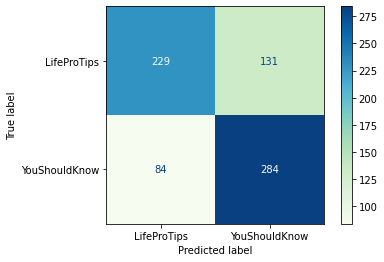

In [20]:
scorer(bs)

In [21]:
bs_importance = zip(fname, bs.best_estimator_.feature_importances_)
bs_df = pd.DataFrame(bs_importance,columns=['feature','feature_importance'])
bs_df.sort_values("feature_importance",ascending=False).head(10)

,feature,feature_importance
13089,website,0.008
4879,google,0.008
11669,talking,0.008
674,amazon,0.008
682,american,0.008
11179,start,0.008
10035,right,0.008
2128,clothes,0.008
6762,link,0.008
7190,matter,0.008


In [22]:
save(bs,"bs")

### KNN

In [23]:
knn_params = {
    'n_neighbors':[5, 10, 25, 50],
    'algorithm':['ball_tree', 'kd_tree'],
    'p':[1,2]
}

knn = GridSearchCV(KNeighborsClassifier(),
                  param_grid=knn_params,
                  verbose = 1,
                  n_jobs = -1,
                  cv=5) # 5-fold cross-validation.

knn.fit(X_train_v,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.2s finished
C:\Users\65908\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': [5, 10, 25, 50], 'p': [1, 2]},
             verbose=1)

Training Score: 0.5098488318827302
Testing Score: 0.49038461538461536


              precision    recall  f1-score   support

           0       0.49      0.97      0.65       360
           1       0.41      0.02      0.04       368

    accuracy                           0.49       728
   macro avg       0.45      0.50      0.34       728
weighted avg       0.45      0.49      0.34       728



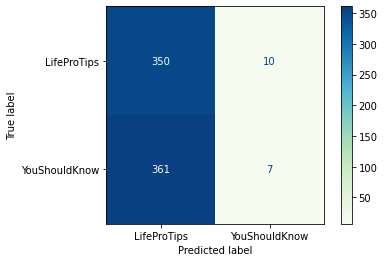

In [24]:
scorer(knn)

The KNearestNeighbor classification performs far worse than all out previous models at only 49% accuracy. However, it is good at predicting `YouShouldKnow` at a sensitivity score that is far higher compared to all of our previous models. However, due to the low accuracy of this model, we will not proceed any further analysis on this model.

### Logistic Regression

In [25]:
lr_params = {
    'penalty':['l1','l2','none'],
    'solver':['liblinear', 'saga'],
    'max_iter':[100,250,500,1000]
}

lr = GridSearchCV(LogisticRegression(random_state=rs),
                  param_grid=lr_params,
                  verbose = 1,
                  n_jobs = -1,
                  cv=5) # 5-fold cross-validation.

lr.fit(X_train_v,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   40.5s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'max_iter': [100, 250, 500, 1000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

Training Score: 0.9949610627576729
Testing Score: 0.7760989010989011


              precision    recall  f1-score   support

           0       0.82      0.70      0.76       360
           1       0.74      0.85      0.79       368

    accuracy                           0.78       728
   macro avg       0.78      0.78      0.77       728
weighted avg       0.78      0.78      0.77       728



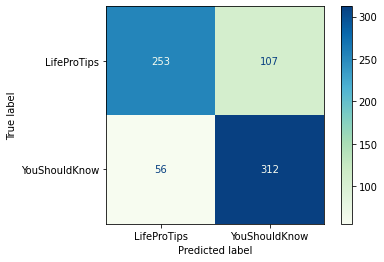

In [26]:
scorer(lr)

In [27]:
lr_unpack = [val for sublist in lr.best_estimator_.coef_ for val in sublist]
lr_importance = zip(fname, lr_unpack)
lr_df = pd.DataFrame(lr_importance,columns=['feature','feature_importance'])
lr_df.sort_values("feature_importance",ascending=False).head(10)

,feature,feature_importance
2128,clothes,1.040767
5810,instead,1.015412
4067,facebook,1.005471
8099,open source,0.960027
6042,job,0.893182
1021,assume,0.860672
7816,new,0.830732
4627,future,0.798746
1234,bed,0.793615
12975,watching,0.762148


In [28]:
save(lr,"lr")

### Naive Bayes

In [29]:
nb_params = {
    'alpha':np.arange(0,1,0.01),
    'fit_prior':[True,False]
}

nb = GridSearchCV(MultinomialNB(),
                  param_grid=nb_params,
                  verbose = 1,
                  n_jobs = -1,
                  cv=5) # 5-fold cross-validation.

nb.fit(X_train_v,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.2s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                         'fit_prior': [True, False]},
             verbose=1)

Training Score: 0.9473202015574896
Testing Score: 0.7541208791208791


              precision    recall  f1-score   support

           0       0.75      0.76      0.75       360
           1       0.76      0.75      0.75       368

    accuracy                           0.75       728
   macro avg       0.75      0.75      0.75       728
weighted avg       0.75      0.75      0.75       728



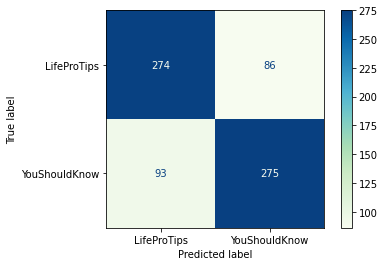

In [30]:
scorer(nb)

In [31]:
nb_unpack = [val for sublist in nb.best_estimator_.coef_ for val in sublist]
nb_importance = zip(fname, nb_unpack)
nb_df = pd.DataFrame(nb_importance,columns=['feature','feature_importance'])
nb_df.sort_values("feature_importance",ascending=False).head(10)

,feature,feature_importance
6084,just,-4.787660
8423,people,-4.806275
11966,time,-5.052118
7034,make,-5.096327
6645,like,-5.142582
6280,know,-5.405825
7728,need,-5.484096
13030,way,-5.506550
12878,want,-5.537296
12539,use,-5.560991


In [32]:
save(nb,"nb")

### Stacking Classifier

Most of the models thus far performs rather similarly at an average accuracy of around 77%. We well see if we can stack these up and obtain better results.

In [33]:
print("\nRandomForest\n",rf.best_params_)
print("\nBoostedTrees\n",bs.best_params_)
print("\nLogisticRegression\n",lr.best_params_)
print("\nNaiveBayes\n",nb.best_params_)


RandomForest
 {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}

BoostedTrees
 {'n_estimators': 250}

LogisticRegression
 {'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

NaiveBayes
 {'alpha': 0.11, 'fit_prior': True}


In [34]:
# Reinstantiating models with best parameters to speed up process without gridsearch

# Random Forest Model for Stacking
prf = RandomForestClassifier(criterion=rf.best_params_['criterion'],
                                random_state=rs,
                                max_features=rf.best_params_['max_features'],
                                n_estimators=rf.best_params_['n_estimators'])
# Boosted Tree Model for Stacking
pbs = AdaBoostClassifier(random_state=rs,
                             n_estimators=bs.best_params_['n_estimators'])

# Logistic Regression Model for Stacking
plr = LogisticRegression(max_iter=lr.best_params_['max_iter'],
                             penalty=lr.best_params_['penalty'],
                            solver=lr.best_params_['solver'])

# Multinomial Naive Bayes Model for Stacking
pnb = MultinomialNB(alpha=nb.best_params_['alpha'],
                        fit_prior=nb.best_params_['fit_prior'])

In [ ]:
estimators = [
    ('rf',prf),
    ('bs',pbs),
    ('lr',plr),
    ('nb',pnb)
]

sm_params = {
    'final_estimator':[RandomForestClassifier(),LogisticRegression(),rf,MultinomialNB(),nb]
}

stackmodel = StackingClassifier(estimators=estimators,
                                cv=5,
                                verbose=1,
                                n_jobs=-1)

sm = GridSearchCV(stackmodel,
                  param_grid=sm_params,
                  verbose = 1,
                  n_jobs = -1,
                  cv=5) # 5-fold cross-validation.

sm.fit(X_train_v,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
scorer(sm)

In [ ]:
save(sm,"sm")

In [ ]:
sm_unpack = [val for sublist in sm.best_estimator_.final_estimator_.coef_ for val in sublist]
sm_importance = zip(['Random Forest','Boosted Trees','Logistic Regression','Multinomial Naive Bayes'], sm_unpack)
sm_df = pd.DataFrame(sm_importance,columns=['estimator','estimator_score'])
sm_df.sort_values("estimator_score",ascending=False).head(20)

We will proceed to analyze the results on the next notebook <a href="./Summary.ipynb">here</a>.